# Late Airline Arrivals

In this project, I will use various machine learning techniques on a dataset of late airline arrivals to predict flight delay. A flight will only count as late if it is over 30 minutes late. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import boto3
import io

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import cross_validation
from sklearn.metrics import r2_score

from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

First, let's take a look at the data we have for the year 2008.

In [ ]:
# Set up packages for loading in data
client = boto3.client('s3') #low-level functional API
resource = boto3.resource('s3') #high-level object-oriented API

# Load in training data labels
obj = client.get_object(Bucket='thinkful-projects', Key='2008.csv')
stream = io.BytesIO(obj['Body'].read())
y2008 = pd.read_csv(stream)
print(y2008.head())

In [3]:
#y2008 = pd.read_csv('2008.csv')
#print(y2008.shape)
#y2008.head()

We have 29 features and 7,009,728 datapoints. Let's see what kind of features we are working with.

In [4]:
print(y2008.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 29 columns):
Year                 int64
Month                int64
DayofMonth           int64
DayOfWeek            int64
DepTime              float64
CRSDepTime           int64
ArrTime              float64
CRSArrTime           int64
UniqueCarrier        object
FlightNum            int64
TailNum              object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin               object
Dest                 object
Distance             int64
TaxiIn               float64
TaxiOut              float64
Cancelled            int64
CancellationCode     object
Diverted             int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtypes: float64(14), int64(10), object(5)
memory usage: 1.5+ GB
None


Many of these features appear to be directly related to the delay, such as WeatherDelay, NASDelay, Security Delay. Others appear to be arbitrarily assigned, such as FlightNum and UniqueCarrier. Features are a mixture of integers, floats, and objects. Categorical objects may be helpful to us in our analysis but may also be too sparsely distributed to be valuable.

Let's look into what kind of values are comprising these features and how those values are correlated with the outcome feature. For each feature that has less than 50 values, we will plot the average delay per value to see if certain values are associated with more delay. This will give us an idea of what features might be important enough to keep as dummy features.


Feature:  Year
1 values
[2008]


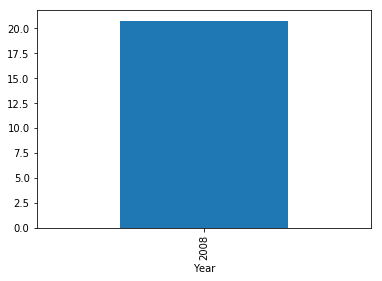


Feature:  Month
12 values
[ 1  2  3  4  5  6  7  8  9 10 11 12]


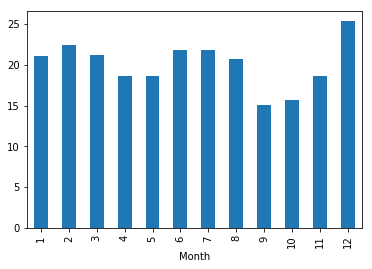


Feature:  DayofMonth
31 values
[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31  2  1]


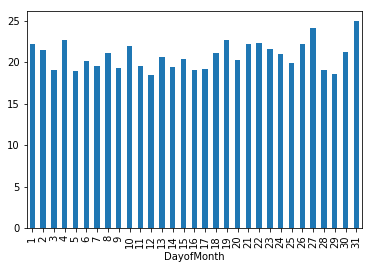


Feature:  DayOfWeek
7 values
[4 5 6 7 1 2 3]


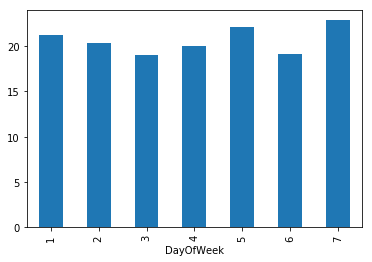


Feature:  DepTime
1441 values
[ 2003.   754.   628.   926.  1829.  1940.  1937.  1039.   617.  1620.]

Feature:  CRSDepTime
1217 values
[1955  735  620  930 1755 1915 1830 1040  615 1620]

Feature:  ArrTime
1441 values
[ 2211.  1002.   804.  1054.  1959.  2121.  2037.  1132.   652.  1639.]

Feature:  CRSArrTime
1378 values
[2225 1000  750 1100 1925 2110 1940 1150  650 1655]

Feature:  UniqueCarrier
20 values
['WN' 'XE' 'YV' 'OH' 'OO' 'UA' 'US' 'DL' 'EV' 'F9' 'FL' 'HA' 'MQ' 'NW' '9E'
 'AA' 'AQ' 'AS' 'B6' 'CO']


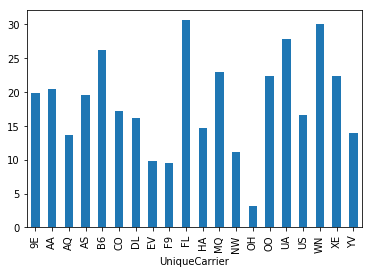


Feature:  FlightNum
7539 values
[ 335 3231  448 1746 3920  378  509  535   11  810]

Feature:  TailNum
5374 values
['N712SW' 'N772SW' 'N428WN' 'N612SW' 'N464WN' 'N726SW' 'N763SW' 'N689SW'
 'N648SW' 'N690SW']

Feature:  ActualElapsedTime
690 values
[ 128.   96.   88.   90.  101.  240.  233.   95.   79.  130.]

Feature:  CRSElapsedTime
526 values
[ 150.  145.   90.  115.  250.   95.  135.   55.   50.  240.]

Feature:  AirTime
664 values
[ 116.  113.   76.   78.   77.   87.  230.  219.   70.  106.]

Feature:  ArrDelay
1154 values
[-14.   2.  14.  -6.  34.  11.  57. -18. -16.   1.]

Feature:  DepDelay
1135 values
[  8.  19.  -4.  34.  25.  67.  -1.   2.   0.   6.]

Feature:  Origin
303 values
['IAD' 'IND' 'ISP' 'JAN' 'JAX' 'LAS' 'LAX' 'LBB' 'LIT' 'MAF']

Feature:  Dest
304 values
['TPA' 'BWI' 'JAX' 'LAS' 'MCI' 'MCO' 'MDW' 'PHX' 'FLL' 'PBI']

Feature:  Distance
1435 values
[ 810  515  688 1591  451  828  162 1489  838  220]

Feature:  TaxiIn
191 values
[  4.   5.   3.   7.   6.   9.   2.  

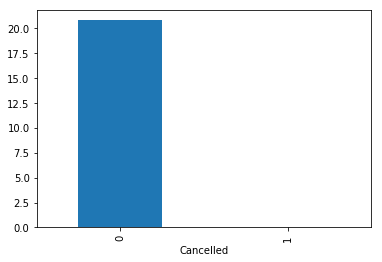


Feature:  CancellationCode
5 values
[nan 'A' 'C' 'B' 'D']


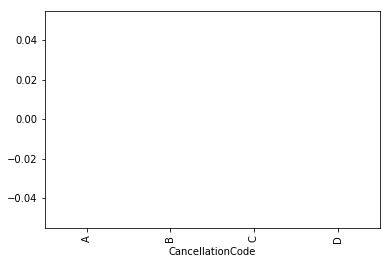


Feature:  Diverted
2 values
[0 1]


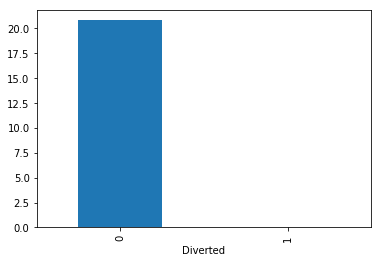


Feature:  CarrierDelay
985 values
[ nan   2.  10.   8.   3.   0.  12.   7.  40.   5.]

Feature:  WeatherDelay
600 values
[  nan    0.   24.   12.   22.    7.   25.  135.    3.    1.]

Feature:  NASDelay
575 values
[ nan   0.   6.  28.   4.  22.   8.   5.   7.  10.]

Feature:  SecurityDelay
157 values
[ nan   0.  10.   8.  12.   3.   9.   6.  11.  14.]

Feature:  LateAircraftDelay
565 values
[ nan  32.  47.  72.  12.  16.  25.   7.  59.  69.]


In [5]:
for column in y2008.columns:
    print('\nFeature: ', str(column))
    print(len(y2008[column].unique()), 'values')

    if len(y2008[column].unique()) < 50:
        print(y2008[column].unique())
        
        mean_per_value = y2008[[column,'LateAircraftDelay']].groupby(column).aggregate(np.mean)
        mean_per_value['LateAircraftDelay'].plot(kind = 'bar')
        plt.show()
    else:
        print(y2008[column].unique()[:10])

Since there is only one value for Year, this feature will be dropped. It appears that month may have an effect on aircraft delay. Day of the month is variable but there are no obvious trends; day of the week is somewhat constant.

Unique carrier seems to have a dramatic effect on the delay, with FL demonstrating the most and OH demonstrating the least. For the rest of the categorical features, there is too wide a range of values to create dummy features, as it would add too many features to the dataset. We will create dummy categories for Unique Carrier and drop the rest of the categorical features.

We will also drop the numerical feature 'FlightNum' as it is assigned arbitrarily and has no predictive power. 'Cancelled' and 'Diverted' will be dropped because they are outcomes, not contributing features. Canceled and diverted flights are incapable of experiencing delay, but they are also unable to be grouped under "on-time", so we will also remove all rows that are positive for either of these features. <br>

It may also be wise to remove all forms of delay: although they are numerical, they are too closely linked to the outcome of interest and will likely lead to overfitting. We will keep them for the time being as we continue exploring the data.

I will also drop the categorical feature UniqueCarrier because although certain carriers might be more prone to delays, adding 20 dummy features to our already large dataframe is too computationally expensive at this time. I will drop TailNum, Origin, and Dest for the same reason.

In [ ]:
# Dropping all rows with canceled or diverted flights
y2008_red = y2008[y2008['Cancelled'] == 0]
y2008_red = y2008_red[y2008_red['Diverted'] == 0]
print(y2008_red.shape)
# Dropping some features and converting others to dummies
y2008_red = y2008_red.drop(['Year','FlightNum', 'TailNum', 'Origin','Dest', 'Cancelled', 'CancellationCode', 'Diverted'], axis = 1)
y2008_red = pd.get_dummies(y2008_red, columns = ['UniqueCarrier'])
print(y2008_red.head())
print(y2008_red.shape)

That got rid of a few hundred thousand rows. We eliminated some columns, but added more dummy features so now we have 41 columns. Now, let's take a look at the range of delays for all the flights in our dataset.

In [7]:
print(y2008_red['LateAircraftDelay'].value_counts())

0.0       825317
15.0       19069
16.0       17678
17.0       16738
18.0       15856
19.0       14969
20.0       14925
21.0       13808
22.0       13327
14.0       13287
13.0       12818
23.0       12416
12.0       12396
24.0       12221
10.0       12009
11.0       11985
25.0       11932
9.0        11461
7.0        10922
8.0        10917
26.0       10878
6.0        10577
27.0       10518
28.0       10172
29.0        9737
30.0        9513
31.0        8995
5.0         8929
4.0         8544
32.0        8532
           ...  
443.0          1
442.0          1
438.0          1
1316.0         1
423.0          1
418.0          1
487.0          1
496.0          1
572.0          1
500.0          1
570.0          1
568.0          1
565.0          1
562.0          1
552.0          1
551.0          1
543.0          1
540.0          1
539.0          1
535.0          1
530.0          1
528.0          1
526.0          1
524.0          1
515.0          1
514.0          1
512.0          1
507.0         

Delays range between 15 minutes to 661 minutes (11 hrs). However, we must remember that flights are only considered late if they are over 30 minutes late. Let's take a look at the correlations we can observe between features.

In [8]:
corrmat = y2008_red.corr()
print(corrmat)

                      Month  DayofMonth  DayOfWeek   DepTime  CRSDepTime  \
Month              1.000000   -0.000402  -0.005350 -0.010321   -0.008426   
DayofMonth        -0.000402    1.000000   0.004762 -0.001555   -0.001745   
DayOfWeek         -0.005350    0.004762   1.000000  0.005660    0.005666   
DepTime           -0.010321   -0.001555   0.005660  1.000000    0.968550   
CRSDepTime        -0.008426   -0.001745   0.005666  0.968550    1.000000   
ArrTime           -0.000377   -0.001505   0.003376  0.713081    0.697293   
CRSArrTime         0.000353   -0.001744   0.005569  0.791431    0.790820   
ActualElapsedTime -0.014061    0.000598   0.012929 -0.017070   -0.017184   
CRSElapsedTime    -0.006345    0.001384   0.015013 -0.013684   -0.011774   
AirTime           -0.012413    0.000950   0.013915 -0.023170   -0.021086   
ArrDelay          -0.042058    0.001607   0.010558  0.178275    0.116894   
DepDelay          -0.030498    0.003299   0.015425  0.201981    0.138850   
Distance    

Although there are too many features to get a thorough read, I can tell that CRSDepTime, DepTime, ArrDelay, DepDelay, TaxiOut, CarrierDelay, and NASDelay all have strong correlation with the outcome (magnitude over 0.1). Naturally, arrival delay and departure delay will correlate strongly (above 0.5). In the same way that 'time in minutes' would correlate strongly with 'time in hours', the different categories of delay are correlated with the final delay but they don't add any predictive power. To build a good predictive model, we will remove all associated 'Delay' features because in the real world, we would not have the luxury of knowing these features well enough in advance to make a useful prediction.

In [47]:
y2008_red = y2008_red.drop(['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay','ArrDelay','DepDelay'], axis = 1)

Now, let's take a look at how much null data there is in our dataset so we can account for it when training our models.

In [10]:
# Calculate NaN values for each column
print(y2008_red.isnull().sum())

Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime                    0
CRSDepTime                 0
ArrTime                    0
CRSArrTime                 0
ActualElapsedTime          0
CRSElapsedTime             0
AirTime                    0
Distance                   0
TaxiIn                     0
TaxiOut                    0
LateAircraftDelay    5330294
UniqueCarrier_9E           0
UniqueCarrier_AA           0
UniqueCarrier_AQ           0
UniqueCarrier_AS           0
UniqueCarrier_B6           0
UniqueCarrier_CO           0
UniqueCarrier_DL           0
UniqueCarrier_EV           0
UniqueCarrier_F9           0
UniqueCarrier_FL           0
UniqueCarrier_HA           0
UniqueCarrier_MQ           0
UniqueCarrier_NW           0
UniqueCarrier_OH           0
UniqueCarrier_OO           0
UniqueCarrier_UA           0
UniqueCarrier_US           0
UniqueCarrier_WN           0
UniqueCarrier_XE           0
UniqueCarrier_YV           0
dtype: int64


After dropping some columns, we see that the outcome is the only feature with NaN values. These values correspond to all the flights that experienced no delay. We will want to convert these to 0, as they will provide a valuable control group for the delayed flights. If we want to model delayed flights, it will be helpful to have a basis of non-delayed flights to compare them to. <br>

In [ ]:
# Convert NaN values in outcome to 0
y2008_red[column] = y2008_red[column].replace(to_replace = 'NaN', value = 0)
print(y2008_red.isnull().sum())

Now let's separate the late flights from the on-time flights so we can evenly sample them and prevent class imbalance. Although we are trying to predict how late flights will be, we will need just as many on-time flights to serve as a comparison for when the predicted flight delay is 0-30 min (considered on-time).

In [ ]:
late = y2008_red.ix[y2008['LateAircraftDelay'] > 30]
print('Number of Delayed Flights:', len(late))

on_time = y2008_red.ix[y2008['LateAircraftDelay'] <= 30]
print('Number of On-time Flights:', len(on_time))

Because there are many more on-time flights than delayed flights, we will need to choose a random sample of on-time flights to match the size of the delayed sample. We will then combine them back into one dataset for input into our machine learning models. <br>

I will also reserve 20% of the data for external validation.

In [ ]:
on_time_red = on_time.sample(len(late))
combined = late.append(on_time_red, ignore_index=True)
X = combined.drop('LateAircraftDelay',axis=1)
Y = combined['LateAircraftDelay']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)

First, I will try  linear regression, as it is very computationally cheap and convenient to run. I will use 5 fold cross-validation on the training dataset to prevent overfitting. Since I am using regression, I will judge different models based on their resultant R2 score.

In [51]:
def run_linear_cv(X, Y):
    lr = linear_model.LinearRegression()
    lr.fit(X, Y)

    scores = cross_validation.cross_val_score(lr, X, Y, cv=5)
    Y_pred = lr.predict(X)

    print(f'Cross Validation Score: {scores.mean()}')
    print(f'R2 Score: {r2_score(Y_pred, Y)}\n')
    
run_linear_cv(X_train, Y_train)

Cross Validation Score: 0.11652020167931998
R2 Score: -6.566591139803253



In [52]:
def run_linear_val(X_train, Y_train, X_test, Y_test):
    lr = linear_model.LinearRegression()
    lr.fit(X_train, Y_train)
    Y_pred = lr.predict(X_test)

    print(f'R2 Score: {r2_score(Y_pred, Y_test)}\n') 
    
run_linear_val(X_train, Y_train, X_test, Y_test)

R2 Score: -6.468742087495736



Using linear regression on the cross-validated dataset, we can see that linear regression is not a valid way to fit our data. The training R2 value is negative, which means that our model fits the data worse than if we had just predicted the mean every time. This is supported by the negative R2 value of the validation dataset. <br>

The poor performance of this model indicates that there is something wrong with our features and that we should take measures to fix the dataset before applying any more machine learning models. <br>

Now that we have added quite a few dummy features, our dataset has become very sparse. Let's try using PCA to condense our feature set into fewer, more impactful features.

Percentage of total variance in dataset explained by each component:
 [  1.28937228e-01   8.14866339e-02   4.20911396e-02   3.55738641e-02
   3.52579274e-02   3.31370610e-02   3.30497964e-02   3.25890409e-02
   3.22155927e-02   3.20585950e-02   3.19513722e-02   3.19411773e-02
   3.17801843e-02   3.15650994e-02   3.13741663e-02   3.11948584e-02
   3.10587097e-02   3.08416091e-02   3.06623722e-02   3.04186019e-02
   3.02034034e-02   2.93120724e-02   2.75937728e-02   2.69108625e-02
   2.51998461e-02   2.36542769e-02   2.21423216e-02   9.14090340e-03
   5.32829966e-03   9.12529753e-04   4.16681009e-04   2.54283847e-32
   1.06189799e-32]
Covariance Matrix:
 [[  1.00000185e+00   6.64285086e-02   1.35210111e-02 ...,   6.25234283e-03
   -2.84734637e-02   2.35937824e-03]
 [  6.64285086e-02   1.00000185e+00   3.37405655e-02 ...,   2.16767509e-03
   -8.51971786e-04  -2.73553216e-03]
 [  1.35210111e-02   3.37405655e-02   1.00000185e+00 ...,   1.56665793e-02
   -2.01825913e-02   1.32993381e-03]
 ..

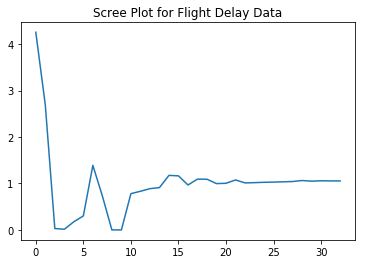

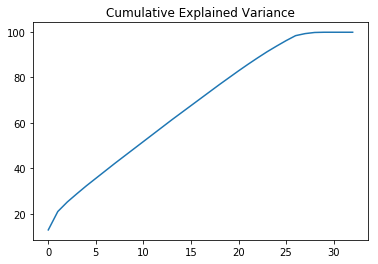

In [15]:
X_scaled = StandardScaler().fit_transform(X_train)
sklearn_pca = PCA()
sklearn_pca.fit(X_scaled)

print(
    'Percentage of total variance in dataset explained by each component:\n',
    sklearn_pca.explained_variance_ratio_
)

Xt = X_scaled.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

plt.plot(eig_val_cov)
plt.title("Scree Plot for Flight Delay Data")
plt.show()

# Calculate cumulative sum of variance explained with [n] features
var=np.cumsum(np.round(sklearn_pca.explained_variance_ratio_, decimals=3)*100)
plt.plot(var)
plt.title("Cumulative Explained Variance")
plt.show()

Our scree plot is not easily interpretable, so another general rule of thumb is to keep only enough features to retain 85% of the variance. Judging by the plot of Cumulative Explained Variance above, we should keep 20 features. We will now use PCA to transform our dataset to include 20 components.

In [16]:
sklearn_pca = PCA(n_components = 20)
sklearn_pca.fit(X_scaled)
X_train_pca = sklearn_pca.transform(X_scaled)
X_train_pca_df = pd.DataFrame(data=X_train_pca)

X_scaled_test = StandardScaler().fit_transform(X_test)
sklearn_pca_test = PCA(n_components = 20)
sklearn_pca_test.fit(X_scaled_test)
X_test_pca = sklearn_pca.transform(X_scaled_test)
X_test_pca_df = pd.DataFrame(data=X_test_pca)

Now, let's try re-running our linear regression model with our PCA-transformed dataset.

In [17]:
run_linear_cv(X_train_pca_df, Y_train)

Cross Validation Score: 0.07527935032065036
R2 Score: -11.26928600595968



In [53]:
run_linear_val(X_train_pca_df, Y_train, X_test_pca_df, Y_test)

R2 Score: -13.685333955570353



In [54]:
print(X_train.columns)

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime',
       'CRSArrTime', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime',
       'Distance', 'TaxiIn', 'TaxiOut', 'UniqueCarrier_9E', 'UniqueCarrier_AA',
       'UniqueCarrier_AQ', 'UniqueCarrier_AS', 'UniqueCarrier_B6',
       'UniqueCarrier_CO', 'UniqueCarrier_DL', 'UniqueCarrier_EV',
       'UniqueCarrier_F9', 'UniqueCarrier_FL', 'UniqueCarrier_HA',
       'UniqueCarrier_MQ', 'UniqueCarrier_NW', 'UniqueCarrier_OH',
       'UniqueCarrier_OO', 'UniqueCarrier_UA', 'UniqueCarrier_US',
       'UniqueCarrier_WN', 'UniqueCarrier_XE', 'UniqueCarrier_YV'],
      dtype='object')


These R2 scores are even worse than with the oringal features, which shows us that linear regression is not a valid method for modeling this data. One possible reason for this is that linear regression assumes no multicollinearity between features, which is not the case here. Several of the features are closely linked to each other, like arrival and departure time. We will use a more complicated algorithm that is better equipped to handle multicollinear features: decision tree/random forest. Since we have already removed so many of the original features, we will continue with our non-PCA-transformed dataset to retain as much variance as possible.

In [59]:
def run_tree_cv (X, Y, depth_max, feature_max, min_split):
    print('training model...')
    dtree = DecisionTreeRegressor(
        max_depth = depth_max,
        random_state = 1,
        max_features = feature_max,
        min_samples_split = min_split
    )
    dtree.fit(X, Y)
    
    scores = cross_validation.cross_val_score(dtree, X, Y, cv=3)
    Y_pred = dtree.predict(X)
    
    current_run = {'max depth': depth_max, 
                    'max features': feature_max,
                    'min samples split': min_split,
                    'cross-val score': scores.mean(),
                    'r2 score': r2_score(Y_pred, Y)}
    runs.append(current_run)

In [60]:
runs = []
depth_maxs = [10, 20]
feature_maxs = [10, 20]
min_splits = [350000, 700000]

for depth_max in depth_maxs:
        for feature_max in feature_maxs:
            for min_split in min_splits:
                run_tree_cv(X_train, Y_train, depth_max, feature_max, min_split)
                    
runs.sort(key = lambda run: run['cross-val score'])
print(runs[-1])

training model...
training model...
training model...
training model...
training model...
training model...
training model...
training model...
{'max depth': 20, 'max features': 20, 'min samples split': 350000, 'cross-val score': 0.048920845198764162, 'r2 score': -8.1612348444303109}


In [61]:
tree_maxdp = runs[-1]['max depth']
tree_maxft = runs[-1]['max features']
tree_minss = runs[-1]['min samples split']

def run_tree_val(X_train, Y_train, X_test, Y_test, depth_max, feature_max, min_split):
    dtree = DecisionTreeRegressor(
        max_depth = depth_max,
        random_state = 1,
        max_features = feature_max,
        min_samples_split = min_split
    )
    dtree.fit(X_train, Y_train)
    
    Y_pred = dtree.predict(X_test)
    
    print(f'Max Depth: {depth_max}, Max Feature = {feature_max}, Min Samples Split = {min_split}')
    print(f'R2 Score: {r2_score(Y_pred, Y_test)}\n')
    
run_tree_val(X_train_pca_df, Y_train, X_test_pca_df, Y_test, tree_maxdp, tree_maxft, tree_minss)

Max Depth: 20, Max Feature = 20, Min Samples Split = 350000
R2 Score: -20.921220557743922



After running 2 different machine learning models, we still have a negative R2 score. It is possible that after removing our most obvious features, this dataset is not able to be fit with a regression equation. While it would be useful to predict a continuous value for how late a flight will be, the features we have may necessitate that we turn this into a classification problem and simply predict "late" or "not late". This is a more realistic situation because we have only retained the features we would know in advance, making the ultimate prediction more relevant for travelers who wish to know as soon as possible about the status of their upcoming flight.<br>

So, we will add a binary feature that specifies 1 if late or 0 if on time and alter our models to predict a binary output. Now that we are predicting a binary output, we will change our success metric from R2 score to conventional accuracy. We will start with logistic regression since it is inexpensive to run. We will hold back on performing PCA at this moment so we can get a baseline read of the new dataset.

In [ ]:
combined['late'] = np.where(combined['LateAircraftDelay']>30, 1, 0)
X_b = combined.drop(['LateAircraftDelay','late'],axis=1)
Y_b = combined['late']
X_train_b, X_test_b, Y_train_b, Y_test_b = train_test_split(X_b, Y_b, test_size = 0.2, random_state = 1)

In [22]:
def run_logistic_cv(X, Y, a, pen):
    lr = LogisticRegression(C = a, penalty = pen, random_state = 1)
    lr.fit(X, Y)

    scores = cross_validation.cross_val_score(lr, X, Y, cv=5, scoring = 'accuracy')
    Y_pred = lr.predict(X)
    
    print(f'Penalty: {pen}\t Lambda: {a}')
    print(f'Cross Validation Score: {scores.mean()}')
    print(f'Accuracy: {accuracy_score(Y_pred, Y)}\n')
    
    current_run = {'penalty': pen, 'lambda': a, 'cross-val score': scores.mean(), 'accuracy': accuracy_score(Y_pred, Y)}
    runs.append(current_run)

In [23]:
runs = []
alphas = [0.01, 0.1, 0.5, 1, 100]
penalties = ['l1','l2']

for pen in penalties:
    for a in alphas:
        run_logistic_cv(X_train_b, Y_train_b, a, pen)

runs.sort(key = lambda run: run['cross-val score'])
print(runs[-1])

Penalty: l1	 Lambda: 0.01
Cross Validation Score: 0.6673459501445415
Accuracy: 0.6674850175043019

Penalty: l1	 Lambda: 0.1
Cross Validation Score: 0.667525814184611
Accuracy: 0.6675221028896933

Penalty: l1	 Lambda: 0.5
Cross Validation Score: 0.6675907135230893
Accuracy: 0.6675258114282323

Penalty: l1	 Lambda: 1
Cross Validation Score: 0.6676074019774603
Accuracy: 0.6675258114282323

Penalty: l1	 Lambda: 100
Cross Validation Score: 0.6675795879899908
Accuracy: 0.6675369370438498

Penalty: l2	 Lambda: 0.01
Cross Validation Score: 0.6676630299008248
Accuracy: 0.6677019670088411

Penalty: l2	 Lambda: 0.1
Cross Validation Score: 0.6674349546156269
Accuracy: 0.6674794546964932

Penalty: l2	 Lambda: 0.5
Cross Validation Score: 0.6673848906965978
Accuracy: 0.6675628968136237

Penalty: l2	 Lambda: 1
Cross Validation Score: 0.6671401267679228
Accuracy: 0.6677798463181629

Penalty: l2	 Lambda: 100
Cross Validation Score: 0.6673589294689865
Accuracy: 0.6673125704622322

{'penalty': 'l2', 'lamb

Despite changing our lambda value, the accuracy remained at roughly 67% for every iteration. While this is certainly better than our negative R2 value, it is not particularly impressive. Our best model came from a ridge regression and a lambda = 0.5 with moderate regularization.

In [38]:
lr_lambda = runs[-1]['lambda']
lr_pen = runs[-1]['penalty']

def run_logistic_val(X_train, Y_train, X_test, Y_test, lr_lambda, lr_pen):
    lr = LogisticRegression(C = lr_lambda, penalty = lr_pen, random_state = 1)
    lr.fit(X_train, Y_train)
    Y_pred = lr.predict(X_test)

    print(f'Lambda: {lr_lambda}')
    print(f'Accuracy: {accuracy_score(Y_pred, Y_test)}\n') 
    
run_logistic_val(X_train_b, Y_train_b, X_test_b, Y_test_b, lr_lambda, lr_pen)

Lambda: 0.01
Accuracy: 0.6686494986055895



After validating with an unseen portion of the original dataset, our accuracy remains unchanged at a low value of **0.67**. This suggests that the model is underfitting. Logistic regression operates on the principle that the features are not multicollinear, which may explain why this model is fitting so poorly. <br>

Let's try random forest, a more complex algorithm suited better for multicollinear features.

In [87]:
def run_forest_cv (X, Y, ft_max, min_leaf,n):

    rfc = RandomForestClassifier(
        max_features = ft_max,
        min_samples_leaf = min_leaf,
        n_estimators = n,
        random_state = 1,
        n_jobs = 4
    )
    rfc.fit(X, Y)
    
    scores = cross_validation.cross_val_score(rfc, X, Y, cv=3, scoring = 'accuracy')
    Y_pred = rfc.predict(X)
    
    print(f'Max Features: {ft_max}, Min Samples Leaf = {min_leaf}, n = {n}')
    print(f'Cross Validation Score: {scores.mean()}')
    print(f'Accuracy Score: {accuracy_score(Y_pred, Y)}\n')
    
    current_run = {'max features': ft_max, 
                    'min samples leaf': min_leaf,
                    'n':n,
                    'cross-val score': scores.mean(),
                    'accuracy': accuracy_score(Y_pred, Y)}
    runs.append(current_run)

runs = []

ft_maxs = [None, 'sqrt', 0.2]
min_leaf = [50, 1000, 10000]
ns = [50]

for ft_max in ft_maxs:
    for min_ in min_leaf:
        for n in ns:
            run_forest_cv(X_train_b, Y_train_b, ft_max, min_, n)
                    
runs.sort(key = lambda run: run['cross-val score'])
print(runs[-1])

Max Features: None, Min Samples Leaf = 50, n = 50
Cross Validation Score: 0.8389678389098304
Accuracy Score: 0.8515657449712217

Max Features: None, Min Samples Leaf = 1000, n = 50
Cross Validation Score: 0.8138814320379281
Accuracy Score: 0.8199467453865781

Max Features: None, Min Samples Leaf = 10000, n = 50
Cross Validation Score: 0.7089445926063265
Accuracy Score: 0.7543185931288198

Max Features: sqrt, Min Samples Leaf = 50, n = 50
Cross Validation Score: 0.8133028933829592
Accuracy Score: 0.8403418530825373

Max Features: sqrt, Min Samples Leaf = 1000, n = 50
Cross Validation Score: 0.7277302186726166
Accuracy Score: 0.7467049635079808

Max Features: sqrt, Min Samples Leaf = 10000, n = 50
Cross Validation Score: 0.6519666307228582
Accuracy Score: 0.668074675132024

Max Features: 0.2, Min Samples Leaf = 50, n = 50
Cross Validation Score: 0.8237368637642971
Accuracy Score: 0.8474696641547499

Max Features: 0.2, Min Samples Leaf = 1000, n = 50
Cross Validation Score: 0.745575718439

With a cross-validation average of **84% accuracy**, the random forest is so far our best model. This was achieved using max features = None, min samples leaf = 50, and 50 estimators. 

In [90]:
forest_maxft = runs[-1]['max features']
forest_minlf = runs[-1]['min samples leaf']
forest_n = runs[-1]['n']

def run_forest_val(X_train, Y_train, X_test, Y_test, feature_max, min_leaf, n):
    rfc = RandomForestClassifier(
        max_features = feature_max,
        min_samples_leaf = min_leaf,
        n_estimators = n,
        random_state = 1,
    )
    rfc.fit(X_train, Y_train)
    
    Y_pred = rfc.predict(X_test)
    
    print(f'Max Feature = {feature_max}, Min Samples Leaf = {min_leaf}, n = {n}')
    print(f'Accuracy: {accuracy_score(Y_pred, Y_test)}\n')
    
run_forest_val(X_train_b, Y_train_b, X_test_b, Y_test_b, forest_maxft, forest_minlf, forest_n)

Max Feature = None, Min Samples Leaf = 50, n = 50
Accuracy: 0.8409333649795289



With a validation accuracy of **0.841**, we can see that the model is not overfitting since it is generalizing well to unseen data. Random forests are generally not prone to overfitting due to them using different subsets of features/obserations for each tree. It is worth noting that in this experiment, the best-performing 'max features' value was None, which decreases the diversity of each individual tree.  Since this ensemble model worked well, let's look into it to see how this model is ranking feature importance.

In [92]:
rfc = RandomForestClassifier(
        max_features = forest_maxft,
        min_samples_leaf = forest_minlf,
        n_estimators = n,
        random_state = 1
    )
rfc.fit(X_train_b, Y_train_b)
rf_feat_importance = pd.DataFrame(rfc.feature_importances_,
                                  index = X_train.columns,
                                  columns=['importance']).sort_values('importance', ascending=False)
print(rf_feat_importance)

                     importance
DepTime            4.859816e-01
CRSDepTime         3.832206e-01
Month              1.830111e-02
UniqueCarrier_OH   1.579300e-02
CRSArrTime         1.028103e-02
UniqueCarrier_EV   9.847556e-03
TaxiOut            9.501843e-03
CRSElapsedTime     8.866123e-03
Distance           7.741443e-03
ArrTime            7.240989e-03
UniqueCarrier_YV   6.601391e-03
ActualElapsedTime  5.968049e-03
TaxiIn             5.162438e-03
DayofMonth         4.527703e-03
AirTime            4.505560e-03
UniqueCarrier_WN   3.347030e-03
UniqueCarrier_OO   2.919802e-03
DayOfWeek          2.656809e-03
UniqueCarrier_UA   1.377384e-03
UniqueCarrier_CO   1.375678e-03
UniqueCarrier_NW   1.090952e-03
UniqueCarrier_XE   7.667410e-04
UniqueCarrier_AA   7.575599e-04
UniqueCarrier_MQ   6.375019e-04
UniqueCarrier_9E   5.362041e-04
UniqueCarrier_FL   4.441396e-04
UniqueCarrier_DL   2.084848e-04
UniqueCarrier_B6   1.769782e-04
UniqueCarrier_US   8.715858e-05
UniqueCarrier_F9   5.410646e-05
UniqueCa

It is clear that most the dummy features for Unique Carrier were not very important in determining the outcome of these flights.  The Carrier 'OH' had slightly more influence than the other carriers. The highest ranking feature was departure time, which is inconclusive because this could potentially mean that flights at certain times of the day are more prone to delay, or it could mean that the departure time (as well as the arrival time) are indicative of the magnitude of delay, which is not insightful. Let's take a look at the relationship between departure time and the outcome.

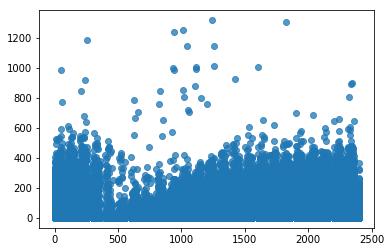

In [81]:
plt.scatter(y2008['DepTime'], y2008['LateAircraftDelay'], alpha = 0.75)
plt.show()

There does seem to be a significant decrease in delay for departure times around 5:00 AM. Perhaps there is less air traffic at this hour and therefore less confounding factors. However, the graph only dips in one section, which leads me to believe it is not significant enough to be a legitimately influential factor. It is only the most influential factor amongst a group of other poor factors. 

Although we were able to obtain an 84% validation accuracy using random forest, I still question the usefulness of the features provided in the dataset. After removing the features that were linked too closely with the outcome to influence any timely predictions, we were left with a feature set with limited predictive power. <br>

First we tried linear regression to predict exactly how late a flight would be, but with our given features we were unable to produce a model that performed better than a horizontal line. We tried one more regression model, decision tree, which confirmed that without the associated delay features, this dataset is not suitable for regression. We attempted PCA to correct for some of the sparsity of the multicollinear features but it did not give us any significant improvement, potentially because we had already lost some information due to prior feature selection. <br>

After converting our task to a classification problem, we tried logistic regression and random forest. Logistic regression performed poorly at 0.67, most likely due to multicollinear features. Random forest performed decently well at 0.84, but with 7 million observations it took a long time to train the model.<br>

In the future, I would ask for more clarification on what we are trying to get out of this dataset. Am I being given this dataset to predict the delay for an airplane that has already taken off? What is the utility in that? Am I being given this dataset to warn passengers about the consequences of booking flights through a certain carrier or airport? Knowing the purpose of the study would greatly improve my experimental design, which would lead to a more conclusive result.